# MRI Classification Using PyTorch
This notebook demonstrates how to load an MRI dataset, split it into training and validation sets, define a custom CNN model, and train the model using PyTorch.

In [1]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import random
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns


## Load dataset
Load the dataset

In [2]:
# Define transformations for training and validation sets
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load datasets from directories
train_dataset = ImageFolder(root='dataset_train', transform=transform_train)
val_dataset = ImageFolder(root='dataset_val', transform=transform_val)

# Create Data Loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

## Data Visualization
Load the dataset and split it into training and validation sets. We will apply data augmentations to the training set.

Visualizing the data ensures a balanced distribution of categories in the training set, which is crucial for preventing model biases and enhancing generalization, ultimately leading to improved performance in accurately categorizing new data.

/home/xj/miniconda3/envs/pytorchenv/lib/python3.9/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/home/xj/miniconda3/envs/pytorchenv/lib/python3.9/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


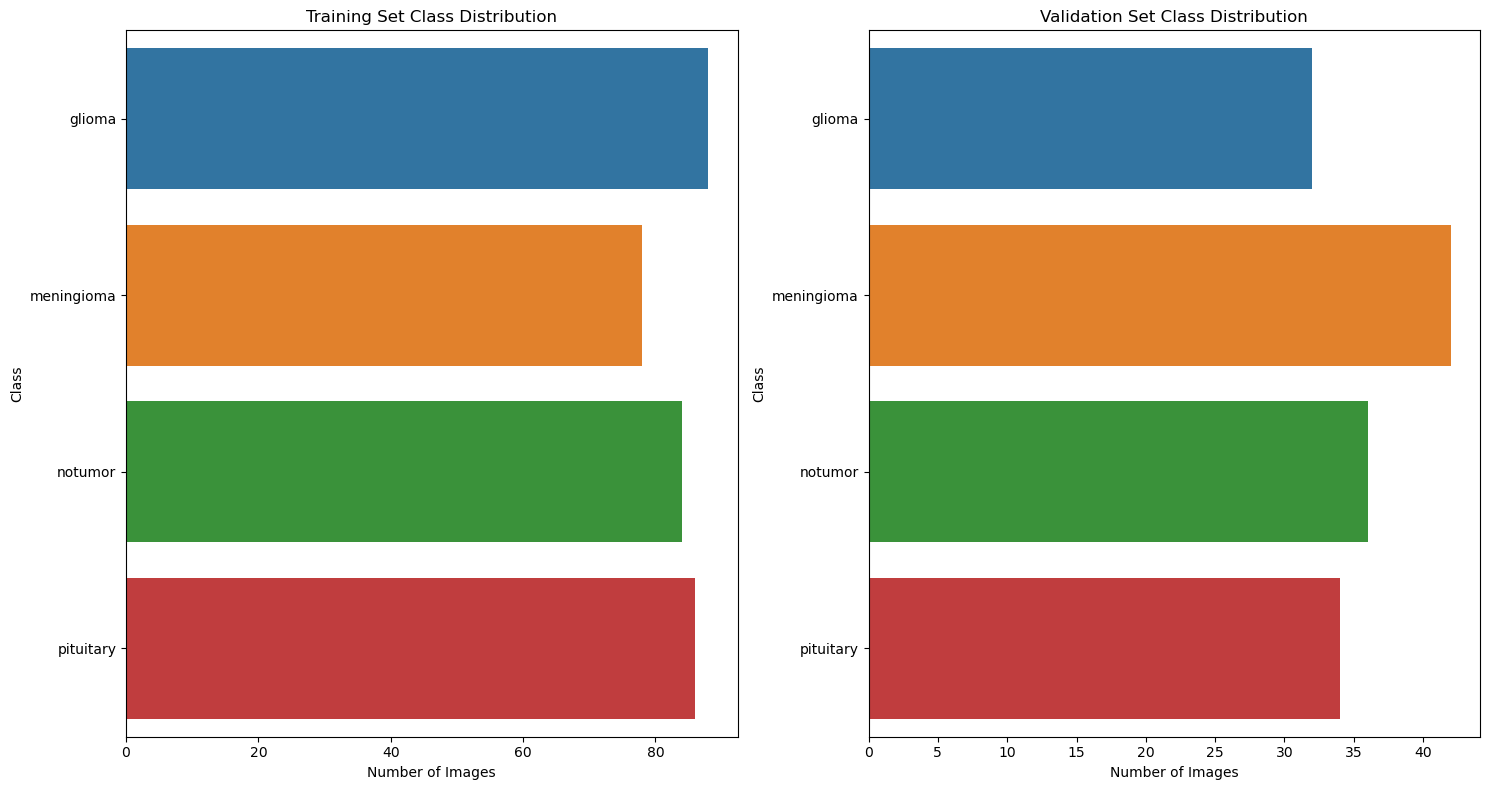

In [3]:
# Get the labels from the datasets
train_labels = [label for _, label in train_dataset]
val_labels = [label for _, label in val_dataset]

# Count the number of instances per class
train_counts = Counter(train_labels)
val_counts = Counter(val_labels)

# Get the class names
class_names = train_dataset.classes

# Create a list of class counts for training and validation
train_class_counts = [train_counts[i] for i in range(len(class_names))]
val_class_counts = [val_counts[i] for i in range(len(class_names))]

# Create a bar plot
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
sns.barplot(y=class_names, x=train_class_counts, ax=ax[0])
sns.barplot(y=class_names, x=val_class_counts, ax=ax[1])

# Set plot titles and labels
ax[0].set_title('Training Set Class Distribution')
ax[0].set_xlabel('Number of Images')
ax[0].set_ylabel('Class')

ax[1].set_title('Validation Set Class Distribution')
ax[1].set_xlabel('Number of Images')
ax[1].set_ylabel('Class')
        
plt.tight_layout()
plt.show()


## Define the Model
Define a custom Convolutional Neural Network (CNN) architecture.

In [4]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.fc1 = nn.Linear(256 * 14 * 14, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 4)
        
        self.dropout = nn.Dropout(0.5)  # Dropout layer with 50% dropout rate

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, 256 * 14 * 14)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.fc4(x)
        return x

# Instantiate the model
model = CustomCNN()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

## Training the Model
Define the loss function and optimizer, and train the model.

In [5]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)  # Adjust weight_decay as needed


# Initialize lists to store loss and accuracy
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Training loop
num_epochs = 25
best_val_loss = float('inf')
patience = 5  # Number of epochs to wait for improvement
epochs_no_improve = 0  # Counter for epochs with no improvement
best_epoch = 0  # Track the best epoch

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects.double() / len(train_loader.dataset)
    
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc.item())
    
    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.4f}')
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    val_corrects = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            _, preds = torch.max(outputs, 1)
            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)
    
    val_loss /= len(val_loader.dataset)
    val_acc = val_corrects.double() / len(val_loader.dataset)
    
    val_losses.append(val_loss)
    val_accuracies.append(val_acc.item())
    
    print(f'Epoch {epoch + 1}/{num_epochs}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')
    
    # Save the model if validation loss has decreased
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch + 1  # Update best epoch
        epochs_no_improve = 0  # Reset counter if validation loss improves
        filename = f'models/custom_cnn_best.pth'
        torch.save(model.state_dict(), filename)
        print(f'Best model saved as {filename}')
    else:
        epochs_no_improve += 1
    
    # Check if early stopping should be applied
    if epochs_no_improve >= patience:
        print('Early stopping!')
        break

print('Training complete')


Epoch 1/25, Train Loss: 1.3825, Train Accuracy: 0.2530
Epoch 1/25, Validation Loss: 1.3198, Validation Accuracy: 0.2500
Best model saved as models/custom_cnn_best.pth
Epoch 2/25, Train Loss: 1.2772, Train Accuracy: 0.2887
Epoch 2/25, Validation Loss: 1.2336, Validation Accuracy: 0.4931
Best model saved as models/custom_cnn_best.pth
Epoch 3/25, Train Loss: 1.2184, Train Accuracy: 0.4554
Epoch 3/25, Validation Loss: 1.1198, Validation Accuracy: 0.5278
Best model saved as models/custom_cnn_best.pth
Epoch 4/25, Train Loss: 1.0426, Train Accuracy: 0.5923
Epoch 4/25, Validation Loss: 1.1415, Validation Accuracy: 0.5069
Epoch 5/25, Train Loss: 1.0115, Train Accuracy: 0.5774
Epoch 5/25, Validation Loss: 0.9709, Validation Accuracy: 0.6250
Best model saved as models/custom_cnn_best.pth
Epoch 6/25, Train Loss: 0.8681, Train Accuracy: 0.6577
Epoch 6/25, Validation Loss: 0.9223, Validation Accuracy: 0.6250
Best model saved as models/custom_cnn_best.pth
Epoch 7/25, Train Loss: 0.7361, Train Accurac

## Model Evaluation
Evaluate the trained model on the validation dataset.

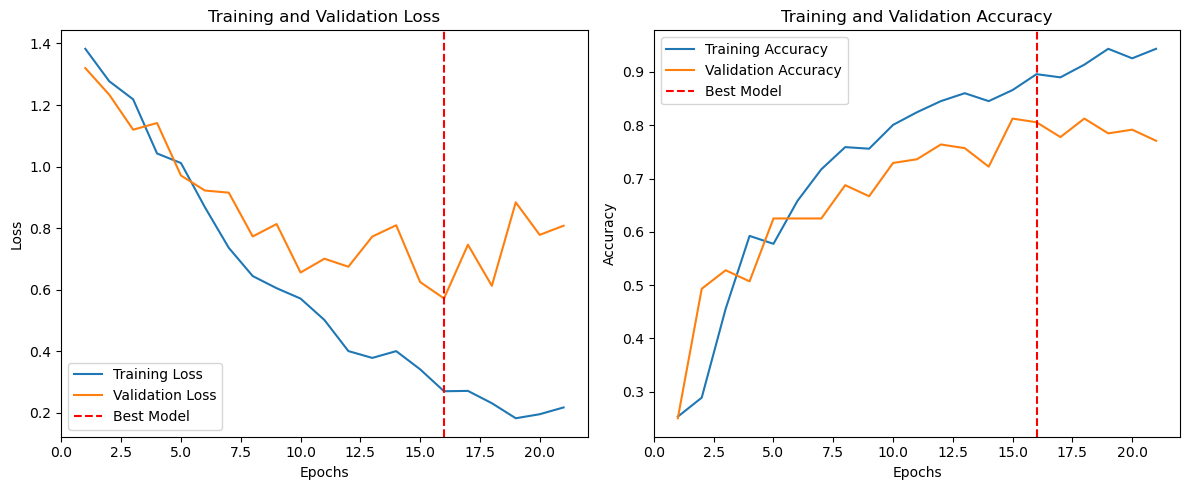

In [6]:
# Plot the training and validation loss and accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.axvline(x=best_epoch, color='r', linestyle='--', label='Best Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.axvline(x=best_epoch, color='r', linestyle='--', label='Best Model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


## Visualization

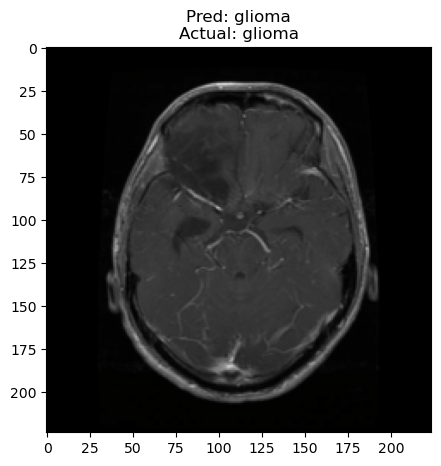

In [7]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Pause a bit so that plots are updated

# Ensure Matplotlib inline backend is set
%matplotlib inline

# Get one batch of validation data
inputs, classes = next(iter(val_loader))

inputs = inputs.to(device)
classes = classes.to(device)
# Load the entire model

# Instantiate the model
model = CustomCNN()

# Load the model state dictionary
model.load_state_dict(torch.load('models/custom_cnn_best.pth'))

model = model.to(device)
# Move the model to the appropriate device
# Make predictions
model.eval()
with torch.no_grad():
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)

# Move the inputs and classes to CPU for visualization
inputs = inputs.cpu()
classes = classes.cpu()
preds = preds.cpu()

# Class names
class_names = train_dataset.classes

# Randomly choose one data point to visualize
index = random.randint(0, len(inputs) - 1)  # Select a random index from the batch
input_image = inputs[index]
predicted_label = class_names[preds[index]]
actual_label = class_names[classes[index]]

# Plot the image along with its predicted and actual labels
plt.figure(figsize=(5, 5))
imshow(input_image, title=f"Pred: {predicted_label}\nActual: {actual_label}")
plt.show()
